In [ ]:
#!/usr/bin/env python
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import pandas as pd, random, numpy as np, time, math
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from FastChemTokenizerHF import FastChemTokenizerSelfies
from scmt import SchemaAugmentedSOMT, SOMTConfig
from torch.cuda.amp import autocast, GradScaler

# ====================================================
# 0. Setup
# ====================================================
seed = 2025
torch.manual_seed(seed); np.random.seed(seed); random.seed(seed)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🚀 Using {device}")

# ====================================================
# 1. Dataset + Tokenization
# ====================================================
class TextDataset(Dataset):
    def __init__(self, csv_path, tokenizer, seq_len=64):
        df = pd.read_csv(csv_path)
        self.texts = df["SELFIES"].astype(str).tolist() if "SELFIES" in df.columns else df.iloc[:, 0].astype(str).tolist()
        self.tokenizer = tokenizer
        self.seq_len = seq_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        toks = self.tokenizer.encode(self.texts[idx])
        toks = toks[: self.seq_len]
        if len(toks) < self.seq_len:
            toks += [self.tokenizer.pad_token_id] * (self.seq_len - len(toks))
        x = torch.tensor(toks, dtype=torch.long)
        y = torch.roll(x, shifts=-1, dims=0)
        return x, y

tokenizer = FastChemTokenizerSelfies.from_pretrained("./tokenizer_vocab/selftok_reordered")
seq_len = 90
train_ds = TextDataset("./data/test.csv", tokenizer, seq_len)
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
test_loader  = DataLoader(train_ds, batch_size=16, shuffle=False)
vocab_size = tokenizer.vocab_size
print(f"📚 Dataset: {len(train_ds)} samples | Vocab size: {vocab_size}")

# ====================================================
# 2. Model Initialization (modular)
# ====================================================
config = SOMTConfig(vocab_size=vocab_size, d_model=256, nhead=8, num_layers=4, max_len=256, mem_size=128)
model = SchemaAugmentedSOMT(config.vocab_size, d_model=config.d_model, nhead=config.nhead, num_layers=config.num_layers,
                            max_len=config.max_len, mem_size=config.mem_size).to(device)

# ====================================================
# 3. Train & Evaluate with Tracking
# ====================================================
def evaluate(model, loader, criterion):
    model.eval(); total_loss = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits, *_ = model(x)
            loss = criterion(logits.view(-1, vocab_size), y.view(-1))
            total_loss += loss.item()
    avg_loss = total_loss / len(loader)
    return avg_loss, np.exp(avg_loss)

def train_model(epochs=1):
    opt = torch.optim.AdamW(model.parameters(), lr=2e-4, betas=(0.9,0.95), weight_decay=0.01)
    criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
    scaler = GradScaler()  # ✅ Initialize AMP scaler

    history = {"train_loss": [], "eval_loss": [], "ppl": []}
    metrics_log = {"budget": [], "schema_util": [], "routing_entropy": [],
                   "importance_l2": [], "importance_entropy": [],
                   "lm_loss": [], "schema_loss": [], "entropy_reg": []}

    for ep in range(epochs):
        model.train(); total_loss = 0
        pbar = tqdm(train_loader, desc=f"Epoch {ep+1}/{epochs}", leave=False)
        for x, y in pbar:
            x, y = x.to(device), y.to(device)
            opt.zero_grad(set_to_none=True)

            # ✅ Mixed precision forward
            with autocast(dtype=torch.float16):
                logits, _, _, _, aux = model(x)
                loss = criterion(logits.view(-1, vocab_size), y.view(-1))
                total_aux = (
                    aux["importance_entropy"] +
                    aux["importance_l2"] +
                    aux["schema_utility"]
                )
                total_loss_combined = loss + total_aux

            # ✅ Scaled backward
            scaler.scale(total_loss_combined).backward()
            scaler.step(opt)
            scaler.update()

            # Tracking (still FP32)
            with torch.no_grad():
                metrics_log["lm_loss"].append(loss.item())
                metrics_log["schema_loss"].append(aux["schema_utility"].item())
                metrics_log["entropy_reg"].append(aux["importance_entropy"].item())
                metrics_log["importance_l2"].append(aux["importance_l2"].item())

                if hasattr(model, "budget_controller"):
                    dummy = torch.randn(1, model.d_model, device=device)
                    budget = model.budget_controller(dummy).mean().item()
                    metrics_log["budget"].append(budget)

                if hasattr(model, "schema_router"):
                    dummy_keys = torch.randn(4, 8, model.d_model, device=device)
                    routing_probs = F.softmax(model.schema_router(dummy_keys), dim=-1)
                    entropy = -torch.sum(routing_probs * torch.log(routing_probs + 1e-12), dim=-1).mean().item()
                    metrics_log["routing_entropy"].append(entropy)

                metrics_log["schema_util"].append(aux["schema_utility"].item())

            total_loss += loss.item()
            pbar.set_postfix(loss=f"{loss.item():.4f}")

        tr_loss = total_loss / len(train_loader)
        ev_loss, ppl = evaluate(model, test_loader, criterion)
        history["train_loss"].append(tr_loss)
        history["eval_loss"].append(ev_loss)
        history["ppl"].append(ppl)
        print(f"Epoch {ep+1}: train {tr_loss:.3f} | eval {ev_loss:.3f} | ppl {ppl:.2f}")

    return model, history, metrics_log


# ====================================================
# 4. Generation (using integrated API)
# ====================================================
@torch.no_grad()
def generate_text(model, tokenizer, prompt="", max_len=80, temperature=1.8):
    model.eval()
    device = next(model.parameters()).device

    if prompt == "":
        start_id = tokenizer.bos_token_id if tokenizer.bos_token_id is not None else tokenizer.eos_token_id
        input_ids = torch.tensor([[start_id]], dtype=torch.long, device=device)
    else:
        input_ids = torch.tensor([tokenizer.encode(prompt)], dtype=torch.long, device=device)

    # Let model.generate handle decoding if tokenizer is provided
    output = model.generate(
        tokenizer=tokenizer,
        input_ids=input_ids,
        max_length=max_len,
        temperature=temperature,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.pad_token_id,
    )

    # model.generate returns a STRING if tokenizer is passed, else a list of IDs
    if isinstance(output, list):
        return tokenizer.decode(output, skip_special_tokens=True)
    else:
        return output  # already a string

# ====================================================
# 5. Run Training + Generation + Save/Load + Plot
# ====================================================
model, hist, metrics = train_model(epochs=1)

# Save/Load dry test
save_dir = "./checkpoints/somt_w_test"
model.save_pretrained(save_dir)
model_loaded = SchemaAugmentedSOMT.from_pretrained(save_dir).to(device)
print("✅ Model reloaded successfully.")

# Quick sanity generation
print("🧪 Generation Test (Reloaded):")
for i in range(2):
    print(f"--- Sample {i+1} ---")
    print(generate_text(model_loaded, tokenizer, prompt="", max_len=60))

# ====================================================
# 6. Plot tracked metrics (Jupyter-friendly)
# ====================================================
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.plot(metrics["budget"], label="Memory Budget Utilization")
plt.xlabel("Step"); plt.ylabel("Budget"); plt.legend()

plt.subplot(2,2,2)
plt.plot(metrics["schema_util"], label="Schema Utility (EMA)")
plt.xlabel("Step"); plt.ylabel("Utility"); plt.legend()

plt.subplot(2,2,3)
plt.plot(metrics["routing_entropy"], label="Routing Entropy")
plt.xlabel("Step"); plt.ylabel("Entropy"); plt.legend()

plt.subplot(2,2,4)
plt.plot(metrics["lm_loss"], label="LM Loss")
plt.plot(metrics["schema_loss"], label="Schema Loss")
plt.plot(metrics["entropy_reg"], label="Entropy Reg")
plt.xlabel("Step"); plt.ylabel("Loss Components"); plt.legend()

plt.tight_layout()
plt.show()

🚀 Using cuda
✅ Special tokens bound: 0 1 2 3 4
📚 Dataset: 24147 samples | Vocab size: 793


C:\Users\mori\AppData\Local\Temp\ipykernel_8488\1270354053.py:73: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # ✅ Initialize AMP scaler


Epoch 1/1:   0%|          | 0/3019 [00:00<?, ?it/s]

C:\Users\mori\AppData\Local\Temp\ipykernel_8488\1270354053.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(device_type="cuda", dtype=torch.float16):


TypeError: autocast.__init__() got an unexpected keyword argument 'device_type'

In [2]:
@torch.no_grad()
def generate_text(model, tokenizer, prompt="", max_len=80, temperature=1.8):
    model.eval()
    device = next(model.parameters()).device

    if prompt == "":
        start_id = tokenizer.bos_token_id if tokenizer.bos_token_id is not None else tokenizer.eos_token_id
        input_ids = torch.tensor([[start_id]], dtype=torch.long, device=device)
    else:
        input_ids = torch.tensor([tokenizer.encode(prompt)], dtype=torch.long, device=device)

    # Let model.generate handle decoding if tokenizer is provided
    output = model.generate(
        tokenizer=tokenizer,
        input_ids=input_ids,
        max_length=max_len,
        temperature=temperature,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.pad_token_id,
    )

    # model.generate returns a STRING if tokenizer is passed, else a list of IDs
    if isinstance(output, list):
        return tokenizer.decode(output, skip_special_tokens=True)
    else:
        return output  # already a string
print("🧪 Generation Test (Reloaded):")
for i in range(2):
    print(f"--- Sample {i+1} ---")
    print(generate_text(model, tokenizer, prompt="", max_len=60))


🧪 Generation Test (Reloaded):
--- Sample 1 ---


d:\Work\SCMT\scmt\modeling_somt.py:221: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1831.)
  e_std = entropy.std(dim=1, keepdim=True) + 1e-12


[C] [O] [C] [=C] [C] [=C] [N] [=C] [N] [Ring1]
--- Sample 2 ---
[C] [O] [C] [=C] [C] [=C] [Branch2] [Ring1] [C] [N] [N] [=Ring1] [=C] [C] [C] [Branch1] [C] [C] [=C] [C] [C] [C] [Branch2] [C] [N] [Branch1] [C] [C] [C] [C] [Branch1] [C] [C] [C] [O] [=S] [=Branch1] [C] [=O] [Branch2] [Ring1] [C] [C] [C] [=C] [=S] [=C] [C] [=C] [C] [=C] [C] [N] [O] [=C] [#Branch2] [C] [C] [=C] [C] [=C] [C] [C] [C] [O] [C] [C] [C] [C] [P] [N] [C] [C] [N] [C] [N] [C] [=C] [C] [=C] [C] [C] [N] [Branch1] [#C] [C] [N] [C] [C] [N] [C] [=Branch1] [C] [=O] [C] [C] [C] [C] [=N] [Ring1] [N] [C] [O] [C] [O] [C] [=C] [C] [=C] [Branch2] [Ring2] [N] [C] [C] [C] [C] [F] [O] [C] [=C] [C] [=C] [C]


In [1]:
# %% [markdown]
# ### Causality Leak Test for SCMT
# Verifies that changing future tokens does NOT affect logits of past tokens.

# %%
import torch
from scmt.modeling_somt import SchemaAugmentedSOMT  # adjust import path as needed

# Use a tiny config for fast testing
config = {
    "vocab_size": 100,
    "d_model": 64,
    "nhead": 2,
    "num_layers": 2,
    "max_len": 10,
    "mem_size": 16,
    "num_schemas": 8,
}
model = SchemaAugmentedSOMT(**config)
model.eval()  # disable dropout, etc.

# Two inputs: identical prefix, different suffix
x1 = torch.tensor([[10, 20, 30, 40, 50]], dtype=torch.long)  # [B=1, L=5]
x2 = torch.tensor([[10, 20, 30, 99, 88]], dtype=torch.long)  # only last 2 tokens differ

with torch.no_grad():
    logits1, *_ = model(x1)
    logits2, *_ = model(x2)

# Compare logits for first 3 positions (should be identical)
prefix_len = 3
diff = torch.abs(logits1[0, :prefix_len] - logits2[0, :prefix_len]).max().item()

print(f"Max logit difference in first {prefix_len} tokens: {diff:.2e}")

if diff < 1e-5:
    print("✅ PASS: No causality leak detected.")
else:
    print("❌ FAIL: Future tokens affected past predictions — masking may be broken.")

Max logit difference in first 3 tokens: 0.00e+00
✅ PASS: No causality leak detected.


In [4]:
import selfies as sf

tokens = "[C] [O] [C] [=C] [C] [=C] [Branch2] [Ring1] [C] [N] [N] [=Ring1] [=C] [C] [C] [Branch1] [C] [C] [=C] [C] [C] [C] [Branch2] [C] [N] [Branch1] [C] [C] [C] [C] [Branch1] [C] [C] [C] [O] [=S] [=Branch1] [C] [=O] [Branch2] [Ring1] [C] [C] [C] [=C] [=S] [=C] [C] [=C] [C] [=C] [C] [N] [O] [=C] [#Branch2] [C] [C] [=C] [C] [=C] [C] [C] [C] [O] [C] [C] [C] [C] [P] [N] [C] [C] [N] [C] [N] [C] [=C] [C] [=C] [C] [C] [N] [Branch1] [#C] [C] [N] [C] [C] [N] [C] [=Branch1] [C] [=O] [C] [C] [C] [C] [=N] [Ring1] [N] [C] [O] [C] [O] [C] [=C] [C] [=C] [Branch2] [Ring2] [N] [C] [C] [C] [C] [F] [O] [C] [=C] [C] [=C] [C]"
tokens = tokens.replace(" ", "")
print(sf.decoder(tokens))

C=1OC=CC=C(NN=1)CCCC(C)COS(=O)(CC=C=S=CC=CC=CCNOC=C)C=CCCCOCCCCPNC2CNCNC=CC=CCCN2CNCCNC(=O)CCCC=N


In [ ]:
cfg = SOMTConfig(vocab_size=32, d_model=16, nhead=2, num_layers=1)
model = SchemaAugmentedSOMT(**cfg.to_dict())

In [5]:
@torch.no_grad()
def visualize_schemas_correct(model, tokenizer, top_k=8):
    model.eval()
    device = next(model.parameters()).device

    # Get raw token embeddings
    embed_matrix = model.embed.weight.data  # (V, D)

    # Project them into KEY space (same as schema_keys)
    projected_tokens = model.key_proj(embed_matrix)  # (V, D)

    # Normalize both
    schema_norm = F.normalize(model.schema_keys, p=2, dim=-1)  # (S, D)
    token_norm = F.normalize(projected_tokens, p=2, dim=-1)     # (V, D)

    # Compute similarity in KEY space
    sim = torch.mm(schema_norm, token_norm.T)  # (S, V)

    # Decode top tokens
    for i in range(sim.size(0)):
        top_vals, top_ids = torch.topk(sim[i], k=top_k, largest=True)
        tokens = [tokenizer.decode([tid.item()]) for tid in top_ids]
        print(f"Schema {i:2d}: " + " | ".join(f"{t} ({v:.3f})" for t, v in zip(tokens, top_vals)))

In [6]:
visualize_schemas_correct(model, tokenizer, top_k=8)

Schema  0: [S] (0.179) | [O] [=C] [C] [Branch1] [C] (0.177) | [C] [C] [N] [=C] (0.150) | [O] [=C] [Branch1] [O] [C] (0.107) | [C] [C] [C] [Branch1] (0.106) | [O] [C] [C] [=C] (0.105) | [C] [=C] [C] [=Branch1] [C] [=O] (0.104) | [C] [C] [Branch1] [C] [C] [C] (0.102)
Schema  1: [CH1-1] (0.223) | [O] [C] [=C] [C] [=C] [Branch2] (0.173) | [=P] (0.143) | [Cl+1] (0.141) | <s> (0.140) | [C] [O] [C] [=C] [C] [=C] [Branch2] [Ring2] (0.138) | [C] [O] [C] [=C] [Branch1] [C] (0.138) | [NH1] (0.134)
Schema  2: [O] [=C] [Branch1] [N] (0.172) | [18F-1] (0.171) | [O] [=C] [Branch1] [=C] (0.171) | [C] [N] [Branch1] [C] [C] [C] [C] [C] (0.170) | [C] [C] [=C] [C] [=C] [Branch2] [Ring1] (0.165) | 1 (0.158) | [C] [O] [C] [=C] [C] [=C] (0.157) | [=P@] (0.149)
Schema  3: [C] [C] [=Branch1] [C] [=O] [N] [C] [C] (0.222) | [C] [O] [C] [=Branch1] [C] [=O] [C] [=C] (0.167) | [C] [C] [=C] [C] [Branch1] [C] (0.160) | [C] [C] [=C] [Branch1] [C] (0.150) | [NH1] (0.138) | [C] [N] [C] [C] [C] [Branch2] (0.126) | [O] [=

🔍 Evaluation Summary
📘 SCMT Loss: 0.5970 ± 0.5269
📗 GPT-2 Loss: 5.5451 ± 0.0106
-
📘 SCMT PPL: 2.00 ± 1.14
📗 GPT-2 PPL: 255.98 ± 2.73
------------------------------------------------------------
Relative Improvement: 89.23% lower loss
Cohen's d Effect Size: 9.26
Paired t-test: t=16.04, p=0.0039


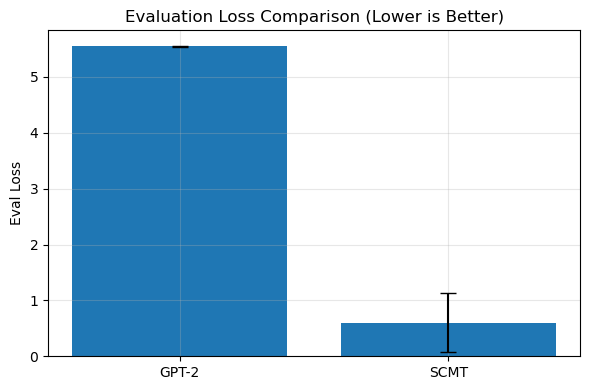

C:\Users\mori\AppData\Local\Temp\ipykernel_736\3696822825.py:67: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([gpt2_ppl, somt_ppl], labels=["GPT-2", "SCMT"])


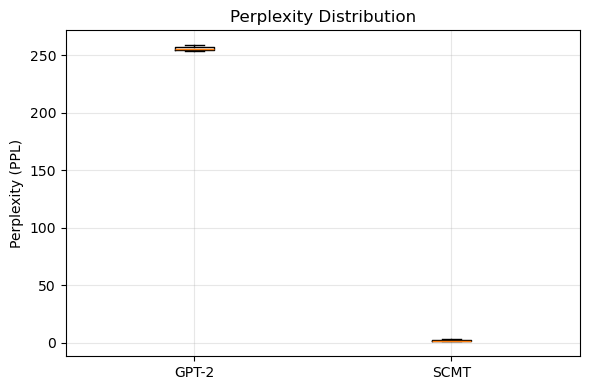

In [1]:
# ====================================================
# 📊 SCMT vs GPT-2 A/B Evaluation Summary
# ====================================================

import json, numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# === Load results ===
with open("mol_ab_results.json") as f:
    data = json.load(f)

somt = data["results"]["somt"]
gpt2 = data["results"]["gpt2"]

somt_losses = np.array([r["loss"] for r in somt])
somt_ppl = np.array([r["ppl"] for r in somt])
gpt2_losses = np.array([r["loss"] for r in gpt2])
gpt2_ppl = np.array([r["ppl"] for r in gpt2])

# === Compute stats ===
def summarize(x):
    return np.mean(x), np.std(x, ddof=1)

somt_mean, somt_std = summarize(somt_losses)
gpt2_mean, gpt2_std = summarize(gpt2_losses)

ppl_mean_somt, ppl_std_somt = summarize(somt_ppl)
ppl_mean_gpt2, ppl_std_gpt2 = summarize(gpt2_ppl)

# paired t-test
tstat, pval = stats.ttest_rel(gpt2_losses, somt_losses)

# effect size (Cohen's d for paired samples)
diff = gpt2_losses - somt_losses
cohens_d = diff.mean() / diff.std(ddof=1)

# === Pretty print summary ===
print("🔍 Evaluation Summary")
print("="*60)
print(f"📘 SCMT Loss: {somt_mean:.4f} ± {somt_std:.4f}")
print(f"📗 GPT-2 Loss: {gpt2_mean:.4f} ± {gpt2_std:.4f}")
print("-")
print(f"📘 SCMT PPL: {ppl_mean_somt:.2f} ± {ppl_std_somt:.2f}")
print(f"📗 GPT-2 PPL: {ppl_mean_gpt2:.2f} ± {ppl_std_gpt2:.2f}")
print("-"*60)
print(f"Relative Improvement: {(1 - somt_mean / gpt2_mean) * 100:.2f}% lower loss")
print(f"Cohen's d Effect Size: {cohens_d:.2f}")
print(f"Paired t-test: t={tstat:.2f}, p={pval:.4f}")
print("="*60)

# === Visualization ===
plt.figure(figsize=(6,4))
labels = ["GPT-2", "SCMT"]
means = [gpt2_mean, somt_mean]
errors = [gpt2_std, somt_std]

plt.bar(labels, means, yerr=errors, capsize=6)
plt.title("Evaluation Loss Comparison (Lower is Better)")
plt.ylabel("Eval Loss")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# === Optional: Boxplot for PPL ===
plt.figure(figsize=(6,4))
plt.boxplot([gpt2_ppl, somt_ppl], labels=["GPT-2", "SCMT"])
plt.title("Perplexity Distribution")
plt.ylabel("Perplexity (PPL)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
